In [3]:
!pip install hopsworks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 6.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.6/691.6 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.6/258.6 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 101.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

# Create an hourly dataset containing pollutants and meterological weather data

In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# Config
LAT = 24.8607
LON = 67.0011
API_KEY = "8d7856b1889c9529a8a22eb24d59ebda"

# Start and end of the period (1 year in Unix timestamps)
START_UNIX = 1730073600  # 28 Oct 2024 00:00 UTC
END_UNIX = 1761436800    # 26 Oct 2025

def fetch_weather_chunk(start, end):
    url = (
        f"https://history.openweathermap.org/data/2.5/history/city"
        f"?lat={LAT}&lon={LON}&type=hour&start={start}&end={end}&appid={API_KEY}"
    )
    r = requests.get(url)
    r.raise_for_status()
    data = r.json()

    rows = []
    for entry in data.get("list", []):
        rows.append({
            "dt": entry["dt"],
            "temp": entry["main"]["temp"],
            "humidity": entry["main"]["humidity"],
            "wind_speed": entry["wind"]["speed"]
        })
    return pd.DataFrame(rows)


def fetch_pollution():
    url = (
        f"http://api.openweathermap.org/data/2.5/air_pollution/history"
        f"?lat={LAT}&lon={LON}&start={START_UNIX}&end={END_UNIX}&appid={API_KEY}"
    )
    r = requests.get(url)
    r.raise_for_status()
    data = r.json()

    rows = []
    for entry in data.get("list", []):
        rows.append({
            "dt": entry["dt"],
            "aqi": entry["main"]["aqi"],
            "co": entry["components"]["co"],
            "no2": entry["components"]["no2"],
            "o3": entry["components"]["o3"],
            "so2": entry["components"]["so2"],
            "pm2_5": entry["components"]["pm2_5"],
            "pm10": entry["components"]["pm10"],
            "nh3": entry["components"]["nh3"],
        })
    return pd.DataFrame(rows)


# Collect weather data in 7-day chunks
weather_frames = []
chunk_size = 7 * 24 * 60 * 60  # 7 days in seconds

current = START_UNIX
while current < END_UNIX:
    chunk_end = min(current + chunk_size, END_UNIX)
    print(f"Fetching weather data {current} → {chunk_end}")
    df = fetch_weather_chunk(current, chunk_end)
    weather_frames.append(df)
    current = chunk_end + 1

weather_df = pd.concat(weather_frames, ignore_index=True)

# Collect AQI + pollutants
print("Fetching pollution data...")
pollution_df = fetch_pollution()

# Merge on timestamp
dataset = pd.merge(weather_df, pollution_df, on="dt", how="inner")

dataset["datetime"] = pd.to_datetime(dataset["dt"], unit="s")

# Save to CSV
dataset.to_csv("karachi_hourly_weather_dataset.csv", index=False)

print("✅ Dataset created: karachi_hourly_weather_dataset.csv")
dataset.head()


Fetching weather data 1730073600 → 1730678400
Fetching weather data 1730678401 → 1731283201
Fetching weather data 1731283202 → 1731888002
Fetching weather data 1731888003 → 1732492803
Fetching weather data 1732492804 → 1733097604
Fetching weather data 1733097605 → 1733702405
Fetching weather data 1733702406 → 1734307206
Fetching weather data 1734307207 → 1734912007
Fetching weather data 1734912008 → 1735516808
Fetching weather data 1735516809 → 1736121609
Fetching weather data 1736121610 → 1736726410
Fetching weather data 1736726411 → 1737331211
Fetching weather data 1737331212 → 1737936012
Fetching weather data 1737936013 → 1738540813
Fetching weather data 1738540814 → 1739145614
Fetching weather data 1739145615 → 1739750415
Fetching weather data 1739750416 → 1740355216
Fetching weather data 1740355217 → 1740960017
Fetching weather data 1740960018 → 1741564818
Fetching weather data 1741564819 → 1742169619
Fetching weather data 1742169620 → 1742774420
Fetching weather data 1742774421 →

,dt,temp,humidity,wind_speed,aqi,co,no2,o3,so2,pm2_5,pm10,nh3,datetime
0,1730073600,299.05,73,1.54,5.0,367.16,7.20,82.25,3.93,107.14,223.22,2.47,2024-10-28 00:00:00
1,1730077200,300.05,65,2.57,5.0,330.45,5.91,85.12,3.70,98.05,218.35,1.76,2024-10-28 01:00:00
2,1730080800,299.05,78,0.00,5.0,363.83,7.88,82.97,4.11,85.95,215.52,1.95,2024-10-28 02:00:00
3,1730084400,299.05,78,2.06,5.0,507.35,16.11,72.96,5.30,78.89,215.66,3.51,2024-10-28 03:00:00
4,1730088000,302.05,74,2.57,5.0,801.09,29.47,59.37,6.85,76.64,214.94,5.83,2024-10-28 04:00:00


In [2]:
pd.read_csv("karachi_hourly_weather_dataset.csv").tail()

,dt,temp,humidity,wind_speed,aqi,co,no2,o3,so2,pm2_5,pm10,nh3,datetime
8459,1761422400,296.05,33,2.57,4.0,374.05,3.19,131.00,6.30,64.81,109.83,1.23,2025-10-25 20:00:00
8460,1761426000,294.05,40,2.57,4.0,423.94,4.41,118.48,6.55,62.58,110.11,1.87,2025-10-25 21:00:00
8461,1761429600,294.05,40,3.09,4.0,438.60,4.72,108.23,6.83,59.46,110.31,2.45,2025-10-25 22:00:00
8462,1761433200,294.05,40,2.06,4.0,434.25,4.43,100.93,6.42,57.56,110.96,2.72,2025-10-25 23:00:00
8463,1761436800,294.05,40,1.54,4.0,419.76,3.92,97.36,6.08,56.49,112.63,2.79,2025-10-26 00:00:00


# Conver Hourly Data to Daily Data

In [3]:
dataset["datetime"] = pd.to_datetime(dataset["dt"], unit="s")

# Extract date only
dataset["date"] = dataset["datetime"].dt.date

# Aggregate by day
daily_df = dataset.groupby("date").agg({
    "temp": "mean",
    "humidity": "mean",
    "wind_speed": "mean",
    "aqi": "mean",
    "co": "mean",
    "no2": "mean",
    "o3": "mean",
    "so2": "mean",
    "pm2_5": "mean",
    "pm10": "mean",
    "nh3": "mean"
}).reset_index()

# Save
daily_df.to_csv("karachi_weather_daily.csv", index=False)

print("✅ Daily dataset created: karachi_weather_daily.csv")
daily_df.head()

✅ Daily dataset created: karachi_weather_daily.csv


,date,temp,humidity,wind_speed,aqi,co,no2,o3,so2,pm2_5,pm10,nh3
0,2024-10-28,303.258333,66.416667,2.959167,4.666667,903.169167,34.630417,54.569583,6.695417,78.464583,205.035833,7.893750
1,2024-10-29,302.133333,73.750000,2.979583,4.750000,731.547500,26.960000,68.112083,6.651250,80.620417,265.637917,6.015417
2,2024-10-30,302.008333,72.541667,2.658333,4.916667,638.226250,22.410833,69.893750,5.121250,72.217917,231.901667,4.842500
3,2024-10-31,301.925000,67.791667,2.100417,4.333333,1428.048333,43.654167,43.777917,12.536250,79.833750,199.299583,14.490417
4,2024-11-01,303.341667,54.208333,2.743750,3.958333,1154.064583,34.251667,61.144167,9.444167,61.936250,138.057500,11.337500


In [4]:
daily_df.tail()

,date,temp,humidity,wind_speed,aqi,co,no2,o3,so2,pm2_5,pm10,nh3
354,2025-10-22,301.716667,32.041667,3.044583,4.750000,423.942500,2.769167,141.127917,7.077500,86.820833,169.778333,1.850417
355,2025-10-23,302.383333,29.500000,2.422083,5.000000,440.482917,2.146250,148.916667,6.770833,95.776667,172.275833,1.228333
356,2025-10-24,300.633333,32.541667,1.671250,4.666667,461.188333,2.822083,143.025000,5.280000,85.746250,146.680417,1.358750
357,2025-10-25,301.300000,26.833333,2.165000,4.541667,533.025000,3.952500,147.560833,7.308333,84.261250,146.527917,1.960000
358,2025-10-26,294.050000,40.000000,1.540000,4.000000,419.760000,3.920000,97.360000,6.080000,56.490000,112.630000,2.790000


In [5]:
import pandas as pd

daily_df = pd.read_csv('karachi_weather_daily.csv')

# US EPA AQI breakpoints
breakpoints = {
    "pm2_5": [
        (0.0, 12.0, 0, 50),
        (12.1, 35.4, 51, 100),
        (35.5, 55.4, 101, 150),
        (55.5, 150.4, 151, 200),
        (150.5, 250.4, 201, 300),
        (250.5, 350.4, 301, 400),
        (350.5, 500.4, 401, 500),
    ],
    "pm10": [
        (0, 54, 0, 50),
        (55, 154, 51, 100),
        (155, 254, 101, 150),
        (255, 354, 151, 200),
        (355, 424, 201, 300),
        (425, 504, 301, 400),
        (505, 604, 401, 500),
    ],
    "o3": [
        (0.000, 0.054, 0, 50),
        (0.055, 0.070, 51, 100),
        (0.071, 0.085, 101, 150),
        (0.086, 0.105, 151, 200),
        (0.106, 0.200, 201, 300),
    ],
    "no2": [
        (0, 53, 0, 50),
        (54, 100, 51, 100),
        (101, 360, 101, 150),
        (361, 649, 151, 200),
        (650, 1249, 201, 300),
        (1250, 1649, 301, 400),
        (1650, 2049, 401, 500),
    ],
    "so2": [
        (0, 35, 0, 50),
        (36, 75, 51, 100),
        (76, 185, 101, 150),
        (186, 304, 151, 200),
        (305, 604, 201, 300),
        (605, 804, 301, 400),
        (805, 1004, 401, 500),
    ],
    "co": [
        (0.0, 4.4, 0, 50),
        (4.5, 9.4, 51, 100),
        (9.5, 12.4, 101, 150),
        (12.5, 15.4, 151, 200),
        (15.5, 30.4, 201, 300),
        (30.5, 40.4, 301, 400),
        (40.5, 50.4, 401, 500),
    ]
}

def calc_aqi(conc, pollutant):
    for (C_low, C_high, I_low, I_high) in breakpoints[pollutant]:
        if C_low <= conc <= C_high:
            return ((I_high - I_low) / (C_high - C_low)) * (conc - C_low) + I_low
    return None  # if outside range

def compute_us_aqi(row):
    aqi_values = []
    for pol in ["pm2_5", "pm10", "o3", "no2", "so2", "co"]:
        val = row[pol]
        if val is not None:
            aqi = calc_aqi(val, pol)
            if aqi is not None:
                aqi_values.append(aqi)
    return max(aqi_values) if aqi_values else None

daily_df["us_aqi"] = daily_df.apply(compute_us_aqi, axis=1)
daily_df.tail()

,date,temp,humidity,wind_speed,aqi,co,no2,o3,so2,pm2_5,pm10,nh3,us_aqi
354,2025-10-22,301.716667,32.041667,3.044583,4.750000,423.942500,2.769167,141.127917,7.077500,86.820833,169.778333,1.850417,167.171979
355,2025-10-23,302.383333,29.500000,2.422083,5.000000,440.482917,2.146250,148.916667,6.770833,95.776667,172.275833,1.228333,171.796171
356,2025-10-24,300.633333,32.541667,1.671250,4.666667,461.188333,2.822083,143.025000,5.280000,85.746250,146.680417,1.358750,166.617136
357,2025-10-25,301.300000,26.833333,2.165000,4.541667,533.025000,3.952500,147.560833,7.308333,84.261250,146.527917,1.960000,165.850382
358,2025-10-26,294.050000,40.000000,1.540000,4.000000,419.760000,3.920000,97.360000,6.080000,56.490000,112.630000,2.790000,151.511170


In [ ]:
# import numpy as np
# daily_df.loc[[355, 356], 'pm2_5'] = np.nan
# daily_df.loc[[355, 356], 'pm10'] = np.nan
# daily_df.tail()
daily_df

,date,temp,humidity,wind_speed,aqi,co,no2,o3,so2,pm2_5,pm10,nh3,us_aqi
0,2025-10-01,302.466667,69.750000,3.965417,2.333333,172.020000,1.787917,81.731250,4.441667,18.890417,35.824583,0.025833,65.280275
1,2025-10-02,303.008333,66.000000,4.867500,1.583333,124.772083,1.807917,61.477917,3.137500,8.383333,16.534583,0.106250,34.930556
2,2025-10-03,302.008333,72.000000,4.994583,1.000000,107.742083,1.932917,45.949167,1.192917,4.865833,10.531667,0.012917,20.274306
3,2025-10-04,301.925000,74.916667,3.557917,1.166667,97.915833,0.140417,53.426667,0.265417,7.719583,13.750000,0.000000,32.164931
4,2025-10-05,302.050000,74.333333,5.572917,1.083333,104.902917,0.069167,54.167083,0.246667,7.547500,15.717083,0.000000,31.447917
5,2025-10-06,302.091667,64.083333,6.065833,2.291667,91.455833,0.066250,54.920833,0.273750,11.271667,50.137083,0.000000,46.965278
6,2025-10-07,301.050000,49.291667,2.787083,2.666667,90.067083,0.055417,56.102083,0.181667,10.614583,55.300417,0.000000,51.148691
7,2025-10-08,300.383333,53.000000,2.143750,2.166667,91.165417,0.044167,53.915417,0.067500,7.790000,39.127500,0.000000,36.229167
8,2025-10-09,300.841667,56.291667,2.872500,2.500000,96.562083,0.050000,64.121250,0.175417,11.408333,50.944167,0.000000,47.534722
9,2025-10-10,300.716667,54.916667,2.830000,2.000000,97.014167,0.040417,64.414583,0.133333,9.907917,35.353333,0.000000,41.282986


In [ ]:
# daily_df['pm2_5'] = daily_df['pm2_5'].interpolate(method="linear")
# daily_df['pm10'] = daily_df['pm10'].interpolate(method="linear")
# daily_df.tail()

,date,temp,humidity,wind_speed,aqi,co,no2,o3,so2,pm2_5,pm10,nh3,us_aqi
355,2025-09-26,301.633333,73.458333,3.194583,1.625000,91.195833,0.045000,45.754583,0.082500,8.343472,33.852639,0.000,0.117857
356,2025-09-27,302.841667,68.208333,3.258750,1.958333,90.800000,0.038750,49.017500,0.118750,9.474444,40.831528,0.000,0.169643
357,2025-09-28,303.758333,68.166667,3.451250,2.416667,90.554583,0.055417,49.945417,0.421250,10.605417,47.810417,0.000,44.268904
358,2025-09-29,305.508333,49.583333,2.957500,2.958333,91.938333,0.129167,50.647083,0.625417,13.453333,71.695000,0.000,59.263182
359,2025-09-30,304.750000,59.900000,2.676000,3.400000,247.494000,2.068000,76.272000,2.503000,37.664000,101.734000,0.143,106.328442


# EDA
## Heatmap

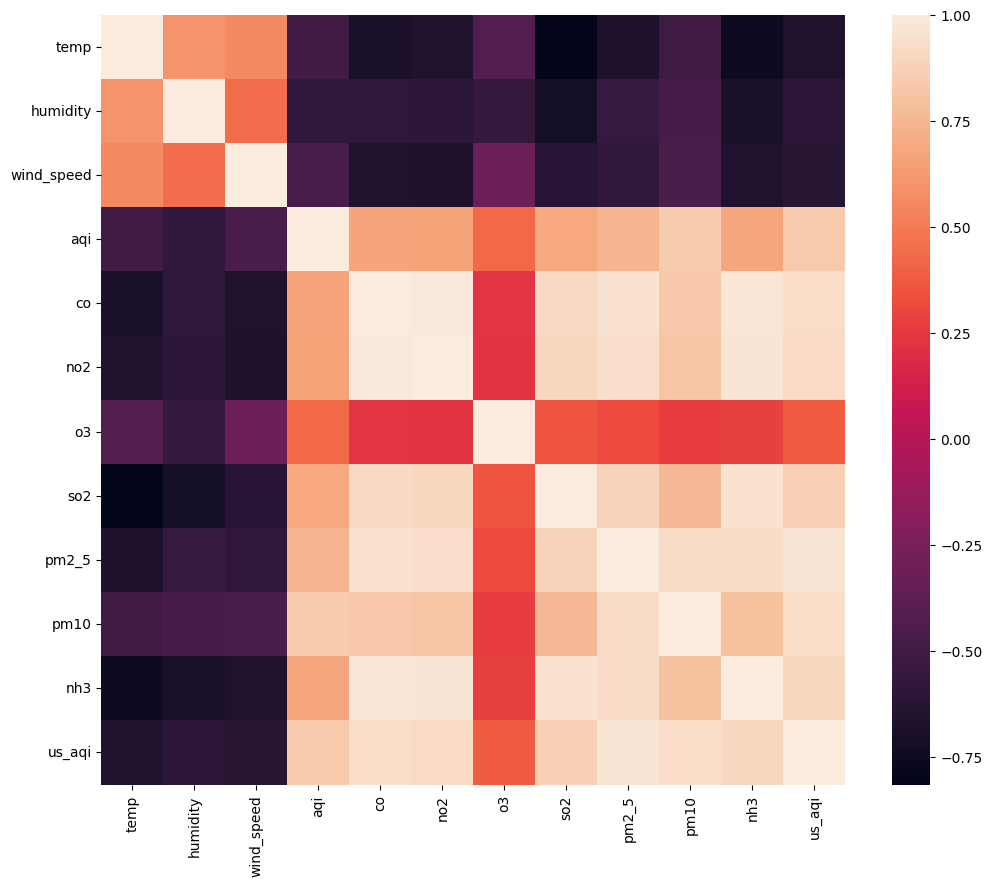

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
corr_matrix = daily_df.select_dtypes(include="number").corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix)
plt.show()

In [ ]:
daily_df.corr(numeric_only=True)['us_aqi'].sort_values(ascending=True)

temp         -0.666735
wind_speed   -0.626865
humidity     -0.600409
o3            0.380478
aqi           0.839734
so2           0.867823
nh3           0.906946
no2           0.920181
co            0.930868
pm10          0.935721
pm2_5         0.970766
us_aqi        1.000000
Name: us_aqi, dtype: float64

## Plot AQI Over Time

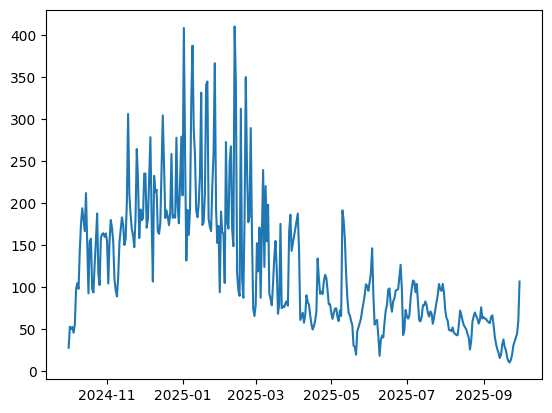

In [ ]:
plt.plot(daily_df['date'], daily_df['us_aqi'])
plt.show()

## Autocorrelation for AQI for 7 Days

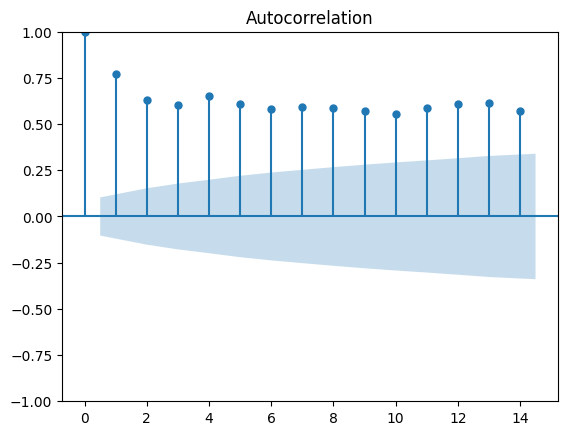

In [ ]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
aqi_series = daily_df['us_aqi']
# acf_values = acf(aqi_series, nlags=7)
# print(acf_values)
plot_acf(aqi_series, lags=14)
plt.show()

# Feature Engineering

## AQI 1, 3 and 7 Days Lag Features

In [6]:
daily_df['aqi_lag_1_day'] = daily_df['us_aqi'].shift(1)
daily_df['aqi_lag_3_day'] = daily_df['us_aqi'].shift(3)
daily_df['aqi_lag_7_day'] = daily_df['us_aqi'].shift(7)
daily_df.head()

,date,temp,humidity,wind_speed,aqi,co,no2,o3,so2,pm2_5,pm10,nh3,us_aqi,aqi_lag_1_day,aqi_lag_3_day,aqi_lag_7_day
0,2024-10-28,303.258333,66.416667,2.959167,4.666667,903.169167,34.630417,54.569583,6.695417,78.464583,205.035833,7.893750,162.857372,NaN,NaN,NaN
1,2024-10-29,302.133333,73.750000,2.979583,4.750000,731.547500,26.960000,68.112083,6.651250,80.620417,265.637917,6.015417,163.970500,162.857372,NaN,NaN
2,2024-10-30,302.008333,72.541667,2.658333,4.916667,638.226250,22.410833,69.893750,5.121250,72.217917,231.901667,4.842500,159.632012,163.970500,NaN,NaN
3,2024-10-31,301.925000,67.791667,2.100417,4.333333,1428.048333,43.654167,43.777917,12.536250,79.833750,199.299583,14.490417,163.564318,159.632012,162.857372,NaN
4,2024-11-01,303.341667,54.208333,2.743750,3.958333,1154.064583,34.251667,61.144167,9.444167,61.936250,138.057500,11.337500,154.323248,163.564318,163.970500,NaN


## Temp 1, 3 and 7 Days Lag Features

In [7]:
daily_df['temp_lag_1_day'] = daily_df['temp'].shift(1)
daily_df['temp_lag_3_day'] = daily_df['temp'].shift(3)
daily_df['temp_lag_7_day'] = daily_df['temp'].shift(7)
daily_df.head()

,date,temp,humidity,wind_speed,aqi,co,no2,o3,so2,pm2_5,pm10,nh3,us_aqi,aqi_lag_1_day,aqi_lag_3_day,aqi_lag_7_day,temp_lag_1_day,temp_lag_3_day,temp_lag_7_day
0,2024-10-28,303.258333,66.416667,2.959167,4.666667,903.169167,34.630417,54.569583,6.695417,78.464583,205.035833,7.893750,162.857372,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-10-29,302.133333,73.750000,2.979583,4.750000,731.547500,26.960000,68.112083,6.651250,80.620417,265.637917,6.015417,163.970500,162.857372,NaN,NaN,303.258333,NaN,NaN
2,2024-10-30,302.008333,72.541667,2.658333,4.916667,638.226250,22.410833,69.893750,5.121250,72.217917,231.901667,4.842500,159.632012,163.970500,NaN,NaN,302.133333,NaN,NaN
3,2024-10-31,301.925000,67.791667,2.100417,4.333333,1428.048333,43.654167,43.777917,12.536250,79.833750,199.299583,14.490417,163.564318,159.632012,162.857372,NaN,302.008333,303.258333,NaN
4,2024-11-01,303.341667,54.208333,2.743750,3.958333,1154.064583,34.251667,61.144167,9.444167,61.936250,138.057500,11.337500,154.323248,163.564318,163.970500,NaN,301.925000,302.133333,NaN


## Wind Speed 1, 3 and 7 Days Lag Features

In [8]:
daily_df['wind_lag_1_day'] = daily_df['wind_speed'].shift(1)
daily_df['wind_lag_3_day'] = daily_df['wind_speed'].shift(3)
daily_df['wind_lag_7_day'] = daily_df['wind_speed'].shift(7)
daily_df.head()

,date,temp,humidity,wind_speed,aqi,co,no2,o3,so2,pm2_5,...,us_aqi,aqi_lag_1_day,aqi_lag_3_day,aqi_lag_7_day,temp_lag_1_day,temp_lag_3_day,temp_lag_7_day,wind_lag_1_day,wind_lag_3_day,wind_lag_7_day
0,2024-10-28,303.258333,66.416667,2.959167,4.666667,903.169167,34.630417,54.569583,6.695417,78.464583,...,162.857372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-10-29,302.133333,73.750000,2.979583,4.750000,731.547500,26.960000,68.112083,6.651250,80.620417,...,163.970500,162.857372,NaN,NaN,303.258333,NaN,NaN,2.959167,NaN,NaN
2,2024-10-30,302.008333,72.541667,2.658333,4.916667,638.226250,22.410833,69.893750,5.121250,72.217917,...,159.632012,163.970500,NaN,NaN,302.133333,NaN,NaN,2.979583,NaN,NaN
3,2024-10-31,301.925000,67.791667,2.100417,4.333333,1428.048333,43.654167,43.777917,12.536250,79.833750,...,163.564318,159.632012,162.857372,NaN,302.008333,303.258333,NaN,2.658333,2.959167,NaN
4,2024-11-01,303.341667,54.208333,2.743750,3.958333,1154.064583,34.251667,61.144167,9.444167,61.936250,...,154.323248,163.564318,163.970500,NaN,301.925000,302.133333,NaN,2.100417,2.979583,NaN


## Humidity 1, 3 and 7 Days Lag Features

In [9]:
daily_df['humidity_lag_1_day'] = daily_df['humidity'].shift(1)
daily_df['humidity_lag_3_day'] = daily_df['humidity'].shift(3)
daily_df['humidity_lag_7_day'] = daily_df['humidity'].shift(7)
daily_df.head()

,date,temp,humidity,wind_speed,aqi,co,no2,o3,so2,pm2_5,...,aqi_lag_7_day,temp_lag_1_day,temp_lag_3_day,temp_lag_7_day,wind_lag_1_day,wind_lag_3_day,wind_lag_7_day,humidity_lag_1_day,humidity_lag_3_day,humidity_lag_7_day
0,2024-10-28,303.258333,66.416667,2.959167,4.666667,903.169167,34.630417,54.569583,6.695417,78.464583,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-10-29,302.133333,73.750000,2.979583,4.750000,731.547500,26.960000,68.112083,6.651250,80.620417,...,NaN,303.258333,NaN,NaN,2.959167,NaN,NaN,66.416667,NaN,NaN
2,2024-10-30,302.008333,72.541667,2.658333,4.916667,638.226250,22.410833,69.893750,5.121250,72.217917,...,NaN,302.133333,NaN,NaN,2.979583,NaN,NaN,73.750000,NaN,NaN
3,2024-10-31,301.925000,67.791667,2.100417,4.333333,1428.048333,43.654167,43.777917,12.536250,79.833750,...,NaN,302.008333,303.258333,NaN,2.658333,2.959167,NaN,72.541667,66.416667,NaN
4,2024-11-01,303.341667,54.208333,2.743750,3.958333,1154.064583,34.251667,61.144167,9.444167,61.936250,...,NaN,301.925000,302.133333,NaN,2.100417,2.979583,NaN,67.791667,73.750000,NaN


## SO2 1, 3 and 7 Days Lag Features

In [10]:
daily_df['so2_lag_1_day'] = daily_df['so2'].shift(1)
daily_df['so2_lag_3_day'] = daily_df['so2'].shift(3)
daily_df['so2_lag_7_day'] = daily_df['so2'].shift(7)
daily_df.head()

,date,temp,humidity,wind_speed,aqi,co,no2,o3,so2,pm2_5,...,temp_lag_7_day,wind_lag_1_day,wind_lag_3_day,wind_lag_7_day,humidity_lag_1_day,humidity_lag_3_day,humidity_lag_7_day,so2_lag_1_day,so2_lag_3_day,so2_lag_7_day
0,2024-10-28,303.258333,66.416667,2.959167,4.666667,903.169167,34.630417,54.569583,6.695417,78.464583,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-10-29,302.133333,73.750000,2.979583,4.750000,731.547500,26.960000,68.112083,6.651250,80.620417,...,NaN,2.959167,NaN,NaN,66.416667,NaN,NaN,6.695417,NaN,NaN
2,2024-10-30,302.008333,72.541667,2.658333,4.916667,638.226250,22.410833,69.893750,5.121250,72.217917,...,NaN,2.979583,NaN,NaN,73.750000,NaN,NaN,6.651250,NaN,NaN
3,2024-10-31,301.925000,67.791667,2.100417,4.333333,1428.048333,43.654167,43.777917,12.536250,79.833750,...,NaN,2.658333,2.959167,NaN,72.541667,66.416667,NaN,5.121250,6.695417,NaN
4,2024-11-01,303.341667,54.208333,2.743750,3.958333,1154.064583,34.251667,61.144167,9.444167,61.936250,...,NaN,2.100417,2.979583,NaN,67.791667,73.750000,NaN,12.536250,6.651250,NaN


## Nh3 1, 3 and 7 Days Lag Features

In [11]:
daily_df['nh3_lag_1_day'] = daily_df['nh3'].shift(1)
daily_df['nh3_lag_3_day'] = daily_df['nh3'].shift(3)
daily_df['nh3_lag_7_day'] = daily_df['nh3'].shift(7)
daily_df.head()

,date,temp,humidity,wind_speed,aqi,co,no2,o3,so2,pm2_5,...,wind_lag_7_day,humidity_lag_1_day,humidity_lag_3_day,humidity_lag_7_day,so2_lag_1_day,so2_lag_3_day,so2_lag_7_day,nh3_lag_1_day,nh3_lag_3_day,nh3_lag_7_day
0,2024-10-28,303.258333,66.416667,2.959167,4.666667,903.169167,34.630417,54.569583,6.695417,78.464583,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-10-29,302.133333,73.750000,2.979583,4.750000,731.547500,26.960000,68.112083,6.651250,80.620417,...,NaN,66.416667,NaN,NaN,6.695417,NaN,NaN,7.893750,NaN,NaN
2,2024-10-30,302.008333,72.541667,2.658333,4.916667,638.226250,22.410833,69.893750,5.121250,72.217917,...,NaN,73.750000,NaN,NaN,6.651250,NaN,NaN,6.015417,NaN,NaN
3,2024-10-31,301.925000,67.791667,2.100417,4.333333,1428.048333,43.654167,43.777917,12.536250,79.833750,...,NaN,72.541667,66.416667,NaN,5.121250,6.695417,NaN,4.842500,7.893750,NaN
4,2024-11-01,303.341667,54.208333,2.743750,3.958333,1154.064583,34.251667,61.144167,9.444167,61.936250,...,NaN,67.791667,73.750000,NaN,12.536250,6.651250,NaN,14.490417,6.015417,NaN


## NO2 1, 3 and 7 Days Lag Features

In [12]:
daily_df['no2_lag_1_day'] = daily_df['no2'].shift(1)
daily_df['no2_lag_3_day'] = daily_df['no2'].shift(3)
daily_df['no2_lag_7_day'] = daily_df['no2'].shift(7)
daily_df.head()

,date,temp,humidity,wind_speed,aqi,co,no2,o3,so2,pm2_5,...,humidity_lag_7_day,so2_lag_1_day,so2_lag_3_day,so2_lag_7_day,nh3_lag_1_day,nh3_lag_3_day,nh3_lag_7_day,no2_lag_1_day,no2_lag_3_day,no2_lag_7_day
0,2024-10-28,303.258333,66.416667,2.959167,4.666667,903.169167,34.630417,54.569583,6.695417,78.464583,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-10-29,302.133333,73.750000,2.979583,4.750000,731.547500,26.960000,68.112083,6.651250,80.620417,...,NaN,6.695417,NaN,NaN,7.893750,NaN,NaN,34.630417,NaN,NaN
2,2024-10-30,302.008333,72.541667,2.658333,4.916667,638.226250,22.410833,69.893750,5.121250,72.217917,...,NaN,6.651250,NaN,NaN,6.015417,NaN,NaN,26.960000,NaN,NaN
3,2024-10-31,301.925000,67.791667,2.100417,4.333333,1428.048333,43.654167,43.777917,12.536250,79.833750,...,NaN,5.121250,6.695417,NaN,4.842500,7.893750,NaN,22.410833,34.630417,NaN
4,2024-11-01,303.341667,54.208333,2.743750,3.958333,1154.064583,34.251667,61.144167,9.444167,61.936250,...,NaN,12.536250,6.651250,NaN,14.490417,6.015417,NaN,43.654167,26.960000,NaN


## CO 1, 3 and 7 Days Lag Features

In [13]:
daily_df['co_lag_1_day'] = daily_df['co'].shift(1)
daily_df['co_lag_3_day'] = daily_df['co'].shift(3)
daily_df['co_lag_7_day'] = daily_df['co'].shift(7)
daily_df.head()

,date,temp,humidity,wind_speed,aqi,co,no2,o3,so2,pm2_5,...,so2_lag_7_day,nh3_lag_1_day,nh3_lag_3_day,nh3_lag_7_day,no2_lag_1_day,no2_lag_3_day,no2_lag_7_day,co_lag_1_day,co_lag_3_day,co_lag_7_day
0,2024-10-28,303.258333,66.416667,2.959167,4.666667,903.169167,34.630417,54.569583,6.695417,78.464583,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-10-29,302.133333,73.750000,2.979583,4.750000,731.547500,26.960000,68.112083,6.651250,80.620417,...,NaN,7.893750,NaN,NaN,34.630417,NaN,NaN,903.169167,NaN,NaN
2,2024-10-30,302.008333,72.541667,2.658333,4.916667,638.226250,22.410833,69.893750,5.121250,72.217917,...,NaN,6.015417,NaN,NaN,26.960000,NaN,NaN,731.547500,NaN,NaN
3,2024-10-31,301.925000,67.791667,2.100417,4.333333,1428.048333,43.654167,43.777917,12.536250,79.833750,...,NaN,4.842500,7.893750,NaN,22.410833,34.630417,NaN,638.226250,903.169167,NaN
4,2024-11-01,303.341667,54.208333,2.743750,3.958333,1154.064583,34.251667,61.144167,9.444167,61.936250,...,NaN,14.490417,6.015417,NaN,43.654167,26.960000,NaN,1428.048333,731.547500,NaN


## PM10 1, 3 and 7 Days Lag Features

In [14]:
daily_df['pm10_lag_1_day'] = daily_df['pm10'].shift(1)
daily_df['pm10_lag_3_day'] = daily_df['pm10'].shift(3)
daily_df['pm10_lag_7_day'] = daily_df['pm10'].shift(7)
daily_df.head()

,date,temp,humidity,wind_speed,aqi,co,no2,o3,so2,pm2_5,...,nh3_lag_7_day,no2_lag_1_day,no2_lag_3_day,no2_lag_7_day,co_lag_1_day,co_lag_3_day,co_lag_7_day,pm10_lag_1_day,pm10_lag_3_day,pm10_lag_7_day
0,2024-10-28,303.258333,66.416667,2.959167,4.666667,903.169167,34.630417,54.569583,6.695417,78.464583,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-10-29,302.133333,73.750000,2.979583,4.750000,731.547500,26.960000,68.112083,6.651250,80.620417,...,NaN,34.630417,NaN,NaN,903.169167,NaN,NaN,205.035833,NaN,NaN
2,2024-10-30,302.008333,72.541667,2.658333,4.916667,638.226250,22.410833,69.893750,5.121250,72.217917,...,NaN,26.960000,NaN,NaN,731.547500,NaN,NaN,265.637917,NaN,NaN
3,2024-10-31,301.925000,67.791667,2.100417,4.333333,1428.048333,43.654167,43.777917,12.536250,79.833750,...,NaN,22.410833,34.630417,NaN,638.226250,903.169167,NaN,231.901667,205.035833,NaN
4,2024-11-01,303.341667,54.208333,2.743750,3.958333,1154.064583,34.251667,61.144167,9.444167,61.936250,...,NaN,43.654167,26.960000,NaN,1428.048333,731.547500,NaN,199.299583,265.637917,NaN


## PM 2.5 1, 3 and 7 Days Lag Features

In [15]:
daily_df['pm2_5_lag_1_day'] = daily_df['pm2_5'].shift(1)
daily_df['pm2_5_lag_3_day'] = daily_df['pm2_5'].shift(3)
daily_df['pm2_5_lag_7_day'] = daily_df['pm2_5'].shift(7)
daily_df.head()

,date,temp,humidity,wind_speed,aqi,co,no2,o3,so2,pm2_5,...,no2_lag_7_day,co_lag_1_day,co_lag_3_day,co_lag_7_day,pm10_lag_1_day,pm10_lag_3_day,pm10_lag_7_day,pm2_5_lag_1_day,pm2_5_lag_3_day,pm2_5_lag_7_day
0,2024-10-28,303.258333,66.416667,2.959167,4.666667,903.169167,34.630417,54.569583,6.695417,78.464583,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-10-29,302.133333,73.750000,2.979583,4.750000,731.547500,26.960000,68.112083,6.651250,80.620417,...,NaN,903.169167,NaN,NaN,205.035833,NaN,NaN,78.464583,NaN,NaN
2,2024-10-30,302.008333,72.541667,2.658333,4.916667,638.226250,22.410833,69.893750,5.121250,72.217917,...,NaN,731.547500,NaN,NaN,265.637917,NaN,NaN,80.620417,NaN,NaN
3,2024-10-31,301.925000,67.791667,2.100417,4.333333,1428.048333,43.654167,43.777917,12.536250,79.833750,...,NaN,638.226250,903.169167,NaN,231.901667,205.035833,NaN,72.217917,78.464583,NaN
4,2024-11-01,303.341667,54.208333,2.743750,3.958333,1154.064583,34.251667,61.144167,9.444167,61.936250,...,NaN,1428.048333,731.547500,NaN,199.299583,265.637917,NaN,79.833750,80.620417,NaN


## Convert date column to datetime

In [16]:
daily_df['date'] = pd.to_datetime(daily_df['date'])

## Add month column in dataset

In [17]:
daily_df['month'] = daily_df['date'].dt.month

In [18]:
daily_df.head()

,date,temp,humidity,wind_speed,aqi,co,no2,o3,so2,pm2_5,...,co_lag_1_day,co_lag_3_day,co_lag_7_day,pm10_lag_1_day,pm10_lag_3_day,pm10_lag_7_day,pm2_5_lag_1_day,pm2_5_lag_3_day,pm2_5_lag_7_day,month
0,2024-10-28,303.258333,66.416667,2.959167,4.666667,903.169167,34.630417,54.569583,6.695417,78.464583,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
1,2024-10-29,302.133333,73.750000,2.979583,4.750000,731.547500,26.960000,68.112083,6.651250,80.620417,...,903.169167,NaN,NaN,205.035833,NaN,NaN,78.464583,NaN,NaN,10
2,2024-10-30,302.008333,72.541667,2.658333,4.916667,638.226250,22.410833,69.893750,5.121250,72.217917,...,731.547500,NaN,NaN,265.637917,NaN,NaN,80.620417,NaN,NaN,10
3,2024-10-31,301.925000,67.791667,2.100417,4.333333,1428.048333,43.654167,43.777917,12.536250,79.833750,...,638.226250,903.169167,NaN,231.901667,205.035833,NaN,72.217917,78.464583,NaN,10
4,2024-11-01,303.341667,54.208333,2.743750,3.958333,1154.064583,34.251667,61.144167,9.444167,61.936250,...,1428.048333,731.547500,NaN,199.299583,265.637917,NaN,79.833750,80.620417,NaN,11


In [19]:
daily_df = daily_df.dropna()
daily_df.head()

,date,temp,humidity,wind_speed,aqi,co,no2,o3,so2,pm2_5,...,co_lag_1_day,co_lag_3_day,co_lag_7_day,pm10_lag_1_day,pm10_lag_3_day,pm10_lag_7_day,pm2_5_lag_1_day,pm2_5_lag_3_day,pm2_5_lag_7_day,month
7,2024-11-04,301.383333,60.541667,2.228750,4.291667,2070.585833,70.902083,54.815833,23.556250,110.910833,...,1468.102500,1154.064583,903.169167,112.917083,138.057500,205.035833,61.922917,61.936250,78.464583,11
8,2024-11-05,301.091667,55.958333,2.958333,4.083333,2060.850833,48.499583,40.605000,14.619167,92.497083,...,2070.585833,536.977083,731.547500,171.355417,95.942917,265.637917,110.910833,36.706667,80.620417,11
9,2024-11-06,301.050000,62.304348,2.615652,3.608696,1212.368696,35.207826,61.791739,10.647826,60.123913,...,2060.850833,1468.102500,638.226250,133.002500,112.917083,231.901667,92.497083,61.922917,72.217917,11
10,2024-11-07,301.216667,71.666667,3.472500,3.125000,665.207083,22.352917,62.391250,6.185417,38.570833,...,1212.368696,2070.585833,1428.048333,87.320870,171.355417,199.299583,60.123913,110.910833,79.833750,11
11,2024-11-08,301.133333,71.875000,2.808750,3.041667,582.873750,19.510417,62.003333,5.582917,33.402083,...,665.207083,2060.850833,1154.064583,75.777917,133.002500,138.057500,38.570833,92.497083,61.936250,11


In [2]:
# daily_df.to_csv('karachi_daily_final.csv', index=False)
import pandas as pd
daily_df = pd.read_csv('karachi_daily_final.csv')
daily_df.head()

,date,temp,humidity,wind_speed,aqi,co,no2,o3,so2,pm2_5,...,co_lag_1_day,co_lag_3_day,co_lag_7_day,pm10_lag_1_day,pm10_lag_3_day,pm10_lag_7_day,pm2_5_lag_1_day,pm2_5_lag_3_day,pm2_5_lag_7_day,month
0,2024-11-04,301.383333,60.541667,2.228750,4.291667,2070.585833,70.902083,54.815833,23.556250,110.910833,...,1468.102500,1154.064583,903.169167,112.917083,138.057500,205.035833,61.922917,61.936250,78.464583,11
1,2024-11-05,301.091667,55.958333,2.958333,4.083333,2060.850833,48.499583,40.605000,14.619167,92.497083,...,2070.585833,536.977083,731.547500,171.355417,95.942917,265.637917,110.910833,36.706667,80.620417,11
2,2024-11-06,301.050000,62.304348,2.615652,3.608696,1212.368696,35.207826,61.791739,10.647826,60.123913,...,2060.850833,1468.102500,638.226250,133.002500,112.917083,231.901667,92.497083,61.922917,72.217917,11
3,2024-11-07,301.216667,71.666667,3.472500,3.125000,665.207083,22.352917,62.391250,6.185417,38.570833,...,1212.368696,2070.585833,1428.048333,87.320870,171.355417,199.299583,60.123913,110.910833,79.833750,11
4,2024-11-08,301.133333,71.875000,2.808750,3.041667,582.873750,19.510417,62.003333,5.582917,33.402083,...,665.207083,2060.850833,1154.064583,75.777917,133.002500,138.057500,38.570833,92.497083,61.936250,11


# Model Training

## Linear Regression as Baseline

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = daily_df.drop(columns=['date', 'us_aqi'])
y = daily_df['us_aqi']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [8]:
from sklearn.metrics import mean_squared_error, r2_score
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse}\nR2: {r2}')

MSE: 66.3843745772551
R2: 0.9547750879545076


## Random Forest

In [9]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=4, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse}\nR2: {r2}')

MSE: 36.55350673755881
R2: 0.975097616906271


## Gradient Boosting Regressor

In [10]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

y_pred = gb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse}\nR2: {r2}')

MSE: 9.749927792572644
R2: 0.9933577799041271


## XGB Regressor

In [11]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.15, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse}\nR2: {r2}')

MSE: 20.810264931087534
R2: 0.9858228324489738


## Neural Network

In [ ]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42
)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse}\nR2: {r2}')

MSE: 82.08637522091429
R2: 0.8605000904604252


In [1]:
import hopsworks
project = hopsworks.login()

Copy your Api Key (first register/login): https://c.app.hopsworks.ai/account/api/generated

Paste it here: ··········




To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1260693


In [2]:
fs = project.get_feature_store()

# daily_df['date'] = pd.to_datetime(daily_df['date'])

# aqi_fg = fs.create_feature_group(
#     name="aqi_features",
#     version=1,
#     description="AQI prediction features with weather and pollutants",
#     primary_key=['date'],
#     event_time='date'
# )

aqi_fg = fs.get_feature_group(name="aqi_features")
# aqi_fg.delete()

# aqi_fg = fs.create_feature_group(
#     name="aqi_features",
#     version=1,
#     description="AQI prediction features with weather and pollutants",
#     primary_key=['date'],
#     event_time='date'
# )

# aqi_fg.insert(daily_df, write_options={"wait_for_job": True})

In [29]:
!pip install confluent-kafka

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 41.1 MB/s eta 0:00:00


## Gradient Boosting Regressor on Feature Store

In [3]:
from sklearn.model_selection import train_test_split

feature_df = aqi_fg.read()
feature_df = feature_df.sort_values('date').reset_index(drop=True)

# feature_df.tail()

X = feature_df.drop(columns=['date', 'us_aqi'])
y = feature_df['us_aqi']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.98s) 


In [4]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

y_pred = gb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse}\nR2: {r2}')

MSE: 7.598846036725101
R2: 0.9968574400009326


In [14]:
import joblib
joblib.dump(gb_model, 'aqi_gb_model.pkl')

model_registry = project.get_model_registry()

aqi_model = model_registry.python.create_model(
    name="aqi_predictor",
    metrics={"mse": mse, "r2": r2},
    description="Gradient Boosting model for AQI prediction"
)

aqi_model.save('aqi_gb_model.pkl')

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /content/aqi_gb_model.pkl: 0.000%|          | 0/133724 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1260693/models/aqi_predictor/2


Model(name: 'aqi_predictor', version: 2)

In [15]:
feature_df.tail()

,date,temp,humidity,wind_speed,aqi,co,no2,o3,so2,pm2_5,...,co_lag_1_day,co_lag_3_day,co_lag_7_day,pm10_lag_1_day,pm10_lag_3_day,pm10_lag_7_day,pm2_5_lag_1_day,pm2_5_lag_3_day,pm2_5_lag_7_day,month
347,2025-10-22 00:00:00+00:00,301.716667,32.041667,3.044583,4.750000,423.942500,2.769167,141.127917,7.077500,86.820833,...,191.755417,120.299583,130.488333,98.730833,86.817917,83.438750,40.131667,33.316250,34.170000,10
348,2025-10-23 00:00:00+00:00,302.383333,29.500000,2.422083,5.000000,440.482917,2.146250,148.916667,6.770833,95.776667,...,423.942500,125.327917,131.486250,169.778333,69.099167,88.112500,86.820833,28.369583,34.303333,10
349,2025-10-24 00:00:00+00:00,300.633333,32.541667,1.671250,4.666667,461.188333,2.822083,143.025000,5.280000,85.746250,...,440.482917,191.755417,155.576667,172.275833,98.730833,114.911250,95.776667,40.131667,46.279167,10
350,2025-10-25 00:00:00+00:00,301.300000,26.833333,2.165000,4.541667,533.025000,3.952500,147.560833,7.308333,84.261250,...,461.188333,423.942500,133.395833,146.680417,169.778333,87.513750,85.746250,86.820833,38.520833,10
351,2025-10-26 00:00:00+00:00,294.050000,40.000000,1.540000,4.000000,419.760000,3.920000,97.360000,6.080000,56.490000,...,533.025000,440.482917,120.299583,146.527917,172.275833,86.817917,84.261250,95.776667,33.316250,10


In [1]:
!pip install shap

Calculating SHAP values for Gradient Boosting model...
Generating SHAP Summary Plot (Beeswarm)...


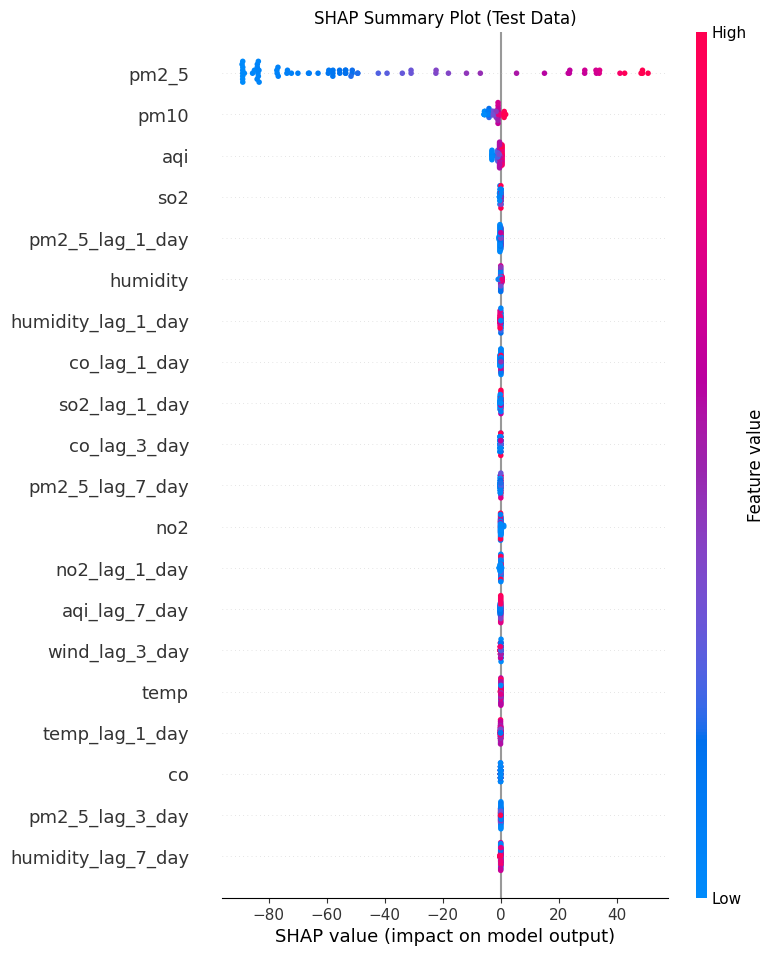


Generating SHAP Feature Importance Plot (Bar)...


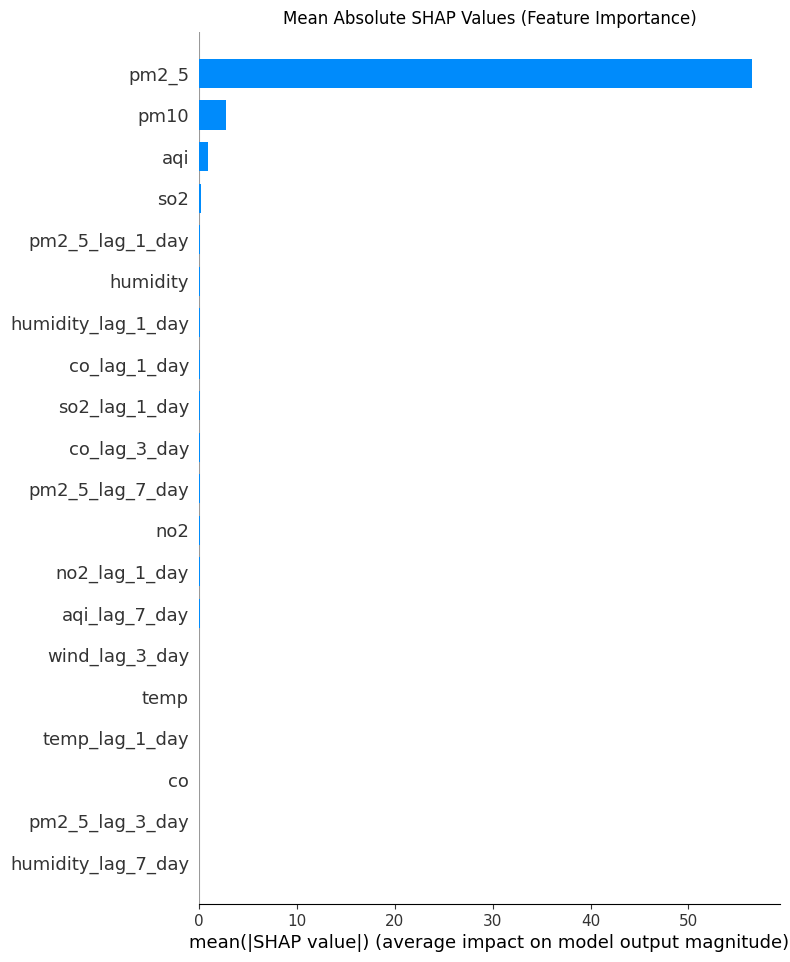

In [5]:
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(gb_model, X_train)

shap_values = explainer(X_test)

print("SHAP Summary Plot (Beeswarm)")
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
plt.title("SHAP Summary Plot (Test Data)")
plt.show()

print("\nSHAP Feature Importance Plot (Bar)")
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Mean Absolute SHAP Values (Feature Importance)")
plt.show()